In [2]:
#NOT SURE YET IF I WILL INCLUDE THIS IN THE CORE EXPERIMENTS FOR THE PAPER, IF AT ALL.

In [3]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets 
import torchvision.transforms as transforms
import torchvision

import matplotlib.pyplot as plt
from skimage.morphology import skeletonize
import numpy as np
from scipy.ndimage import distance_transform_edt
import random as ra

In [4]:
input_size = 784
#intervention_size = dynamic (to be defined later)
hidden_size0 = 32
hidden_size1 = 16
out_size = 1
epochs = 10
batch_size = 64
learning_rate = 0.001

In [5]:
train_dataset = datasets.MNIST(root='./data',
                           train=True,
                           transform=transforms.ToTensor(),
                           download=True)

test_dataset = datasets.MNIST(root='./data',
                           train=False,
                           transform=transforms.ToTensor())

In [6]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                          batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

In [7]:
class Net(nn.Module):
    def __init__(self, input_size, intervention_size, hidden_size0, hidden_size1, out_size, masks, threshold):
        super(Net, self).__init__()
        self.fc0 = nn.Linear(input_size, intervention_size)
        self.fc1 = nn.Linear(intervention_size, hidden_size0)
        self.fc2 = nn.Linear(hidden_size0, hidden_size1)
        self.fc3 = nn.Linear(hidden_size1, out_size)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.init_weights()
        
        self.register_buffer('fc0_mask', masks.bool())
        self.threshold = threshold

    def init_weights(self):
        nn.init.xavier_uniform_(self.fc0.weight, gain=nn.init.calculate_gain('tanh')) 
        nn.init.xavier_uniform_(self.fc1.weight, gain=nn.init.calculate_gain('tanh'))
        nn.init.xavier_uniform_(self.fc2.weight, gain=nn.init.calculate_gain('tanh'))
        nn.init.xavier_uniform_(self.fc3.weight, gain=nn.init.calculate_gain('tanh'))

    def forward(self, x):
        out = self.relu(self.fc0(x))
        out = self.relu(self.fc1(out))
        out = self.relu(self.fc2(out))
        out = self.fc3(out)
        return out

    def apply_fc0_constraints(self):
        #forcing isolated attention. Neurons will only see certain parts of the input.
        #This forces the net to work more conceptually.

        with torch.no_grad():
            w = self.fc0.weight.data
            mask = self.fc0_mask

            w[~mask] = 0

            #threshold
            #w[mask & (w.abs() < self.threshold)] = (
            #    self.threshold * w[mask & (w.abs() < self.threshold)].sign() #the fucking sign become 0 for 0 from init!!!
            #)

            idx = mask & (w.abs() < self.threshold)
            w_sign = torch.sign(w[idx])
            w_sign[w_sign == 0] = 1 #now it won't be 0!
            w[idx] = self.threshold * w_sign

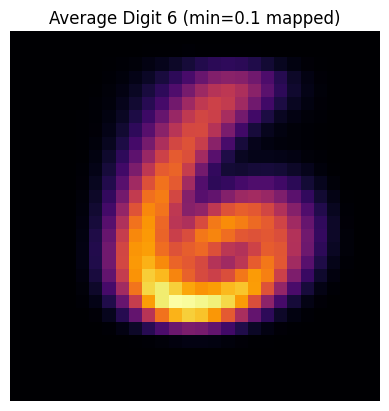

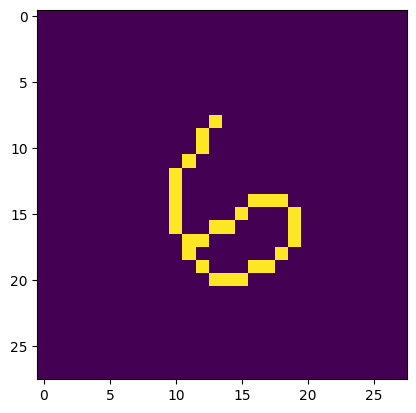

In [8]:
transform = transforms.ToTensor()
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=False)

bin_digit = 6 #the net will focus on specifically one digit, making concepts more  interpretable as they can be associated with one digit only.

sum_img = torch.zeros((28, 28))
count = 0

for imgs, labels in trainloader:
    mask = labels == bin_digit
    if mask.any():
        selected_imgs = imgs[mask]  #[N, 1, 28, 28]
        sum_img += selected_imgs.sum(dim=0).squeeze(0)
        count += mask.sum().item()

avg_img = sum_img / count

plt.imshow(avg_img, cmap='inferno')
plt.axis('off')
plt.title(f'Average Digit {bin_digit} (min=0.1 mapped)')
plt.show()

#print(avg_img)

to_skel = (avg_img > 0.5).float()

skel = skeletonize(to_skel.cpu().numpy())
plt.imshow(skel)

#print(to_skel)

In [9]:
def extract_concepts(skeleton, img):
    img_np = img.cpu().numpy()
    skeleton_np = skeleton.astype(bool)

    size = 10
    maxoverlap = 7
    height, width = 28, 28

    neighbors_offsets = [(dy, dx) for dy in [-1,0,1] for dx in [-1,0,1] if not (dy == 0 and dx == 0)]

    def get_neighbors(p):
        y, x = p
        result = []
        for dy, dx in neighbors_offsets:
            ny, nx = y + dy, x + dx
            if 0 <= ny < height and 0 <= nx < width and skeleton_np[ny, nx]:
                result.append((ny, nx))
        return result

    groups = []
    groups_sets = []

    def dfs(path, visited):
        if len(path) == size:
            path_set = set(path)
            if not any(len(path_set & g) > maxoverlap for g in groups_sets):
                groups.append(np.array(path))
                groups_sets.append(path_set)
            return

        candidates = set()
        for p in path:
            for n in get_neighbors(p):
                if n not in visited:
                    candidates.add(n)

        for n in candidates:
            visited.add(n)
            dfs(path + [n], visited)
            visited.remove(n)

    all_pixels = list(zip(*np.nonzero(skeleton_np)))

    for start in all_pixels:
        dfs([start], set([start]))

    tensor_groups = torch.stack([
        torch.zeros((height, width), dtype=torch.uint8).index_put_(
            (torch.tensor(g[:, 0]), torch.tensor(g[:, 1])), 
            torch.ones(len(g), dtype=torch.uint8)
        ) for g in groups
    ])

    original_clusters = torch.zeros_like(tensor_groups)
    original_clusters = []

    for i in range(tensor_groups.shape[0]):
        mask = tensor_groups[i].numpy()
        inverted_mask = 1 - mask
        distance = distance_transform_edt(inverted_mask)
        within_range_mask = (distance <= 3.5).astype(np.float32)
        new_input = torch.from_numpy(img_np * within_range_mask).float()
        original_clusters.append(new_input)

    return tensor_groups, original_clusters

In [10]:
tensors, originals = extract_concepts(skeleton=skel, img=avg_img)

In [11]:
ind = 0

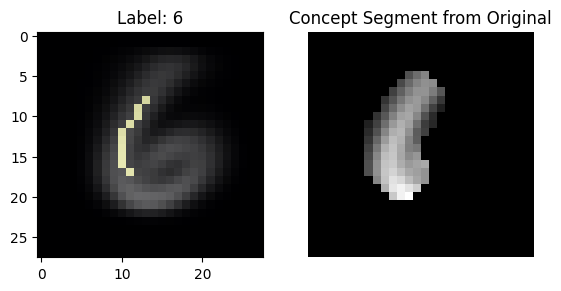

12


In [12]:
plt.subplot(1, 2, 1)
plt.imshow(avg_img.view(28, 28), cmap="gray") #or squeeze()
plt.imshow(tensors[ind].cpu().numpy(), cmap='inferno', alpha=0.6)
plt.title(f"Label: {bin_digit}")

plt.subplot(1, 2, 2)
plt.title('Concept Segment from Original')
plt.imshow(originals[ind], cmap='gray')

plt.axis('off')
plt.show()
print(len(tensors))

ind = ind + 1 if ind < len(tensors) - 1 else 0
#run this cell repeatedly to iterate through the extracted concepts.

In [13]:
#input: 784 grayscale
#hidden layer 0: N neurons
#hidden layer 1: 32 neurons
#hidden layer 2: 16 neurons
#out layer 3: 1 neuron

#masks from 784 to N:
all_masks = []

for cluster in originals:
    binary_mask = (cluster.view(-1) != 0) #size (784,)
    all_masks.append(binary_mask)

len(all_masks) #N clusters -> each cluster defines an isolated area of focus for each of the N hidden neurons

mask_tensor = torch.stack(all_masks).to(torch.bool)


#constraints for FFN for each cluster-neuron pair:
#weights to neuron that aren't in the binary positive (1) cluster must be 0
#weights from the 1's (the corresponding cluster) must retain a weight >= 0.5, or <= -0.5
#(tanh is used, or should I use ReLU and only allow >= 0.5?, idk which one would make it easier for the net to adapt to the constraints...)

In [14]:
net = Net(input_size, len(mask_tensor), hidden_size0, hidden_size1, out_size, masks=mask_tensor, threshold=1)
net.load_state_dict(torch.load(f"stored_model_weights_conceptual/conceptual_bin_model_{bin_digit}.pth"))

CUDA = torch.cuda.is_available()
if CUDA:
    net = net.cuda()

criterion = nn.BCEWithLogitsLoss() #uses sigmoid
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate) #sorry, using "z" over "s" makes code more readable to most people

#Training
for epoch in range(0): #epochs):
    total_train_samples = 0
    correct_train = 0
    running_loss = 0
    for i, (images, labels) in enumerate(train_loader):   
        #(batch,1,28,28)
        images = images.view(-1, 28*28)   
        if CUDA:
            images = images.cuda()
            labels = labels.cuda()

        #modifying the dataset for binary prediction, unlike mnist:
        bin_mask = (labels == bin_digit)
        other_mask = ~bin_mask

        bin_images = images[bin_mask]
        bin_labels = labels[bin_mask]

        other_images = images[other_mask]
        other_labels = labels[other_mask]

        n_bin = bin_images.size(0)

        if n_bin == 0:
            continue

        target_other_per_digit = n_bin

        balanced_other_images = []
        balanced_other_labels = []

        for digit in range(10):
            if digit == bin_digit:
                continue
            digit_mask = (other_labels == digit)
            digit_images = other_images[digit_mask]
            digit_labels = other_labels[digit_mask]

            if digit_images.size(0) < target_other_per_digit and digit_images.size(0) > 0:
                indices = torch.randint(0, digit_images.size(0), (target_other_per_digit,), device=digit_images.device)
            else:
                indices = torch.randperm(digit_images.size(0), device=digit_images.device)[:target_other_per_digit]

            balanced_other_images.append(digit_images[indices])
            balanced_other_labels.append(digit_labels[indices])

        if len(balanced_other_images) == 0:
            continue

        balanced_other_images = torch.cat(balanced_other_images, dim=0)
        balanced_other_labels = torch.cat(balanced_other_labels, dim=0)

        batch_images = torch.cat([bin_images, balanced_other_images], dim=0)
        batch_labels = torch.cat([bin_labels, balanced_other_labels], dim=0)

        perm = torch.randperm(batch_images.size(0), device=batch_images.device)
        batch_images = batch_images[perm]
        batch_labels = batch_labels[perm]

        batch_labels_bin = (batch_labels == bin_digit).float().view(-1, 1)

        ######

        outputs = net(batch_images)       
        predicted = (torch.sigmoid(outputs) >= 0.5).float()                                            
        total_train_samples += batch_labels_bin.size(0)  #total examples used in training
        correct_train += (predicted == batch_labels_bin).sum().item()
        loss = criterion(outputs, batch_labels_bin)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()                                   
        optimizer.step()                             
        net.apply_fc0_constraints()

    accuracy = 100 * correct_train / total_train_samples
    print(f'Epoch [{epoch+1}/{epochs}], Training Loss: {running_loss / len(train_loader):.3f}, Training Accuracy: {accuracy:.3f}%')
    
print("DONE TRAINING!")

torch.save(net.state_dict(), f'stored_model_weights_conceptual/conceptual_bin_model_{bin_digit}.pth') #'binary_ffn_all.pth')


DONE TRAINING!


In [15]:
from torch.utils.data import DataLoader, Subset
import torch

num_samples = 500

idx_digit = [i for i, (_, label) in enumerate(test_dataset) if label == bin_digit]
idx_not_digit = [i for i, (_, label) in enumerate(test_dataset) if label != bin_digit]

idx_digit = idx_digit[:num_samples // 2]
idx_not_digit = idx_not_digit[:num_samples // 2]

balanced_indices = idx_digit + idx_not_digit
balanced_subset = Subset(test_dataset, balanced_indices)
balanced_loader = DataLoader(balanced_subset, batch_size=64, shuffle=False)

net.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in balanced_loader:
        if CUDA:
            images = images.cuda()
            labels = labels.cuda()
            
        images = images.view(-1, 28*28)
        labels_bin = (labels == bin_digit).float().view(-1, 1)

        outputs = net(images)
        predicted = (torch.sigmoid(outputs) >= 0.5).float()

        correct += (predicted == labels_bin).sum().item()
        total += labels_bin.size(0)

print(f'Balanced Accuracy on 50% "{bin_digit}" vs 50% not-{bin_digit}: {100 * correct / total:.2f}%')


Balanced Accuracy on 50% "6" vs 50% not-6: 88.80%


In [16]:
def compute_final_contributions(net, activations_fc0, target):
    w1 = net.fc1.weight.detach().cpu()
    w2 = net.fc2.weight.detach().cpu()

    contribs = torch.zeros(activations_fc0.shape[0])

    for i in range(activations_fc0.shape[0]):
        a0 = activations_fc0[i].item()
        total = 0
        for j in range(w1.shape[0]):
            w0 = w1[j, i].item()
            a1 = torch.tanh(torch.tensor(a0 * w0))
            w1_2 = w2[target, j].item()
            total += a1.item() * w1_2
        contribs[i] = total

    return contribs



/tmp/ipykernel_85661/887982760.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


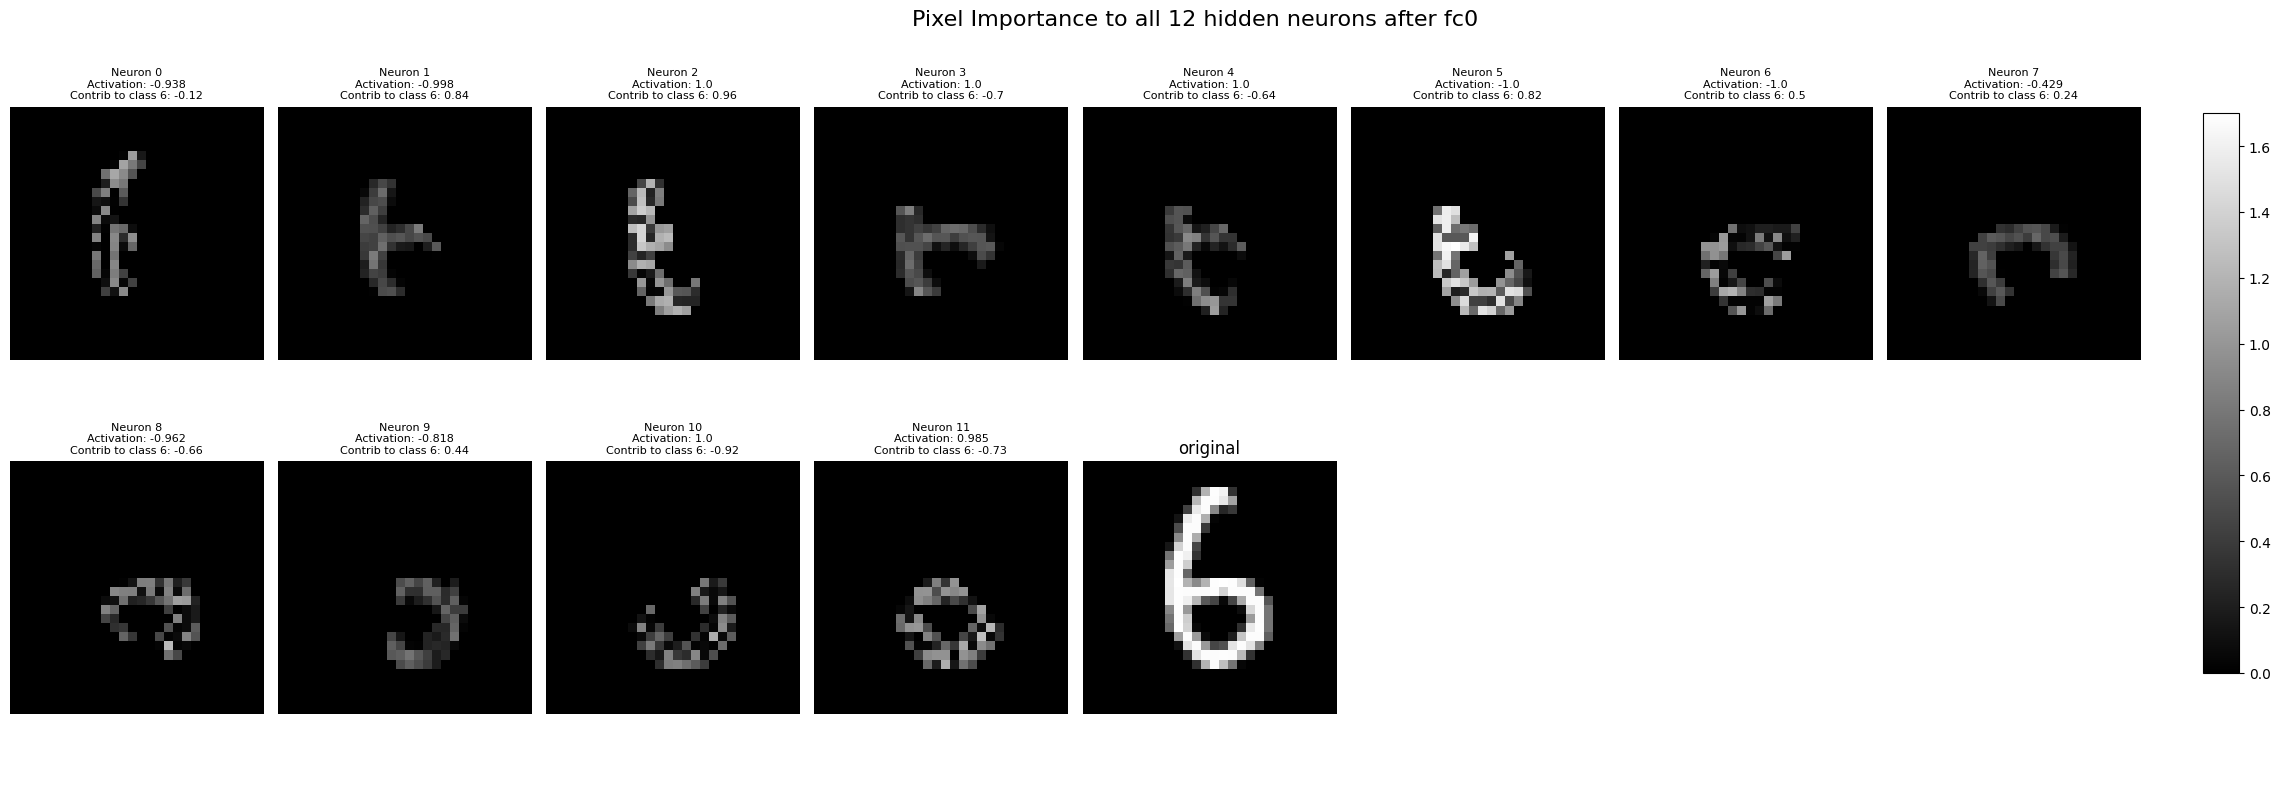

Prediction: Input is a 6


In [17]:

inputs, labels = next(iter(test_loader))

#search wanted digit:
while True:
    ind = ra.randrange(0, len(inputs))
    if labels[ind] == bin_digit:
        img = inputs[ind].squeeze()
        break
    
#img = torch.full((28, 28), 255).float()

img_flat = img.view(-1)
weights = net.fc0.weight.detach().cpu()
biases = net.fc0.bias.detach().cpu()
contribs = weights * img_flat #[32, 784]

#normalise to [0, 1]
contribs_imgs = (contribs / contribs.max()).view(-1, 28, 28)

mask = torch.where(
    contribs_imgs == 0,
    torch.tensor(0.0, device=contribs_imgs.device),
    torch.tensor(1.0, device=contribs_imgs.device)
)

contribs_imgs += biases[:, None, None]
contribs_imgs *= mask #remove bias where background = 0 for visualisation 

activations = torch.tanh(net.fc0(img.view(1, -1).cuda())).squeeze()
final_contribution = [round(con.item(), 2) for con in compute_final_contributions(net, activations, bin_digit)]

rows = -(-len(mask_tensor) // 8)
fig, axes = plt.subplots(rows, 8, figsize=(24, rows * 4))
vmax = contribs_imgs.max().item()
vmin = contribs_imgs.min().item()

for i, ax in enumerate(axes.flat):
    if i <= len(mask_tensor) - 1:
        im = ax.imshow(contribs_imgs[i].abs(), cmap='gray', vmin=0, vmax=vmax)
        ax.set_title(f'Neuron {i}\nActivation: {round(activations[i].item(), 3)}\nContrib to class {bin_digit}: {final_contribution[i]}', fontsize=8)
    ax.axis('off')

ax = axes.flat[len(mask_tensor)]
ax.imshow(img, cmap="gray")
ax.set_title("original")

fig.suptitle(f'Pixel Importance to all {len(mask_tensor)} hidden neurons after fc0', fontsize=16)
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.tight_layout(rect=[0, 0, 0.9, 1])
plt.show()

output = net(img.view(-1).cuda())
pred = (torch.sigmoid(output) >= 0.5).float()
print(f"Prediction: Input is {(1-int(pred.item())) * 'not '}a {bin_digit}")

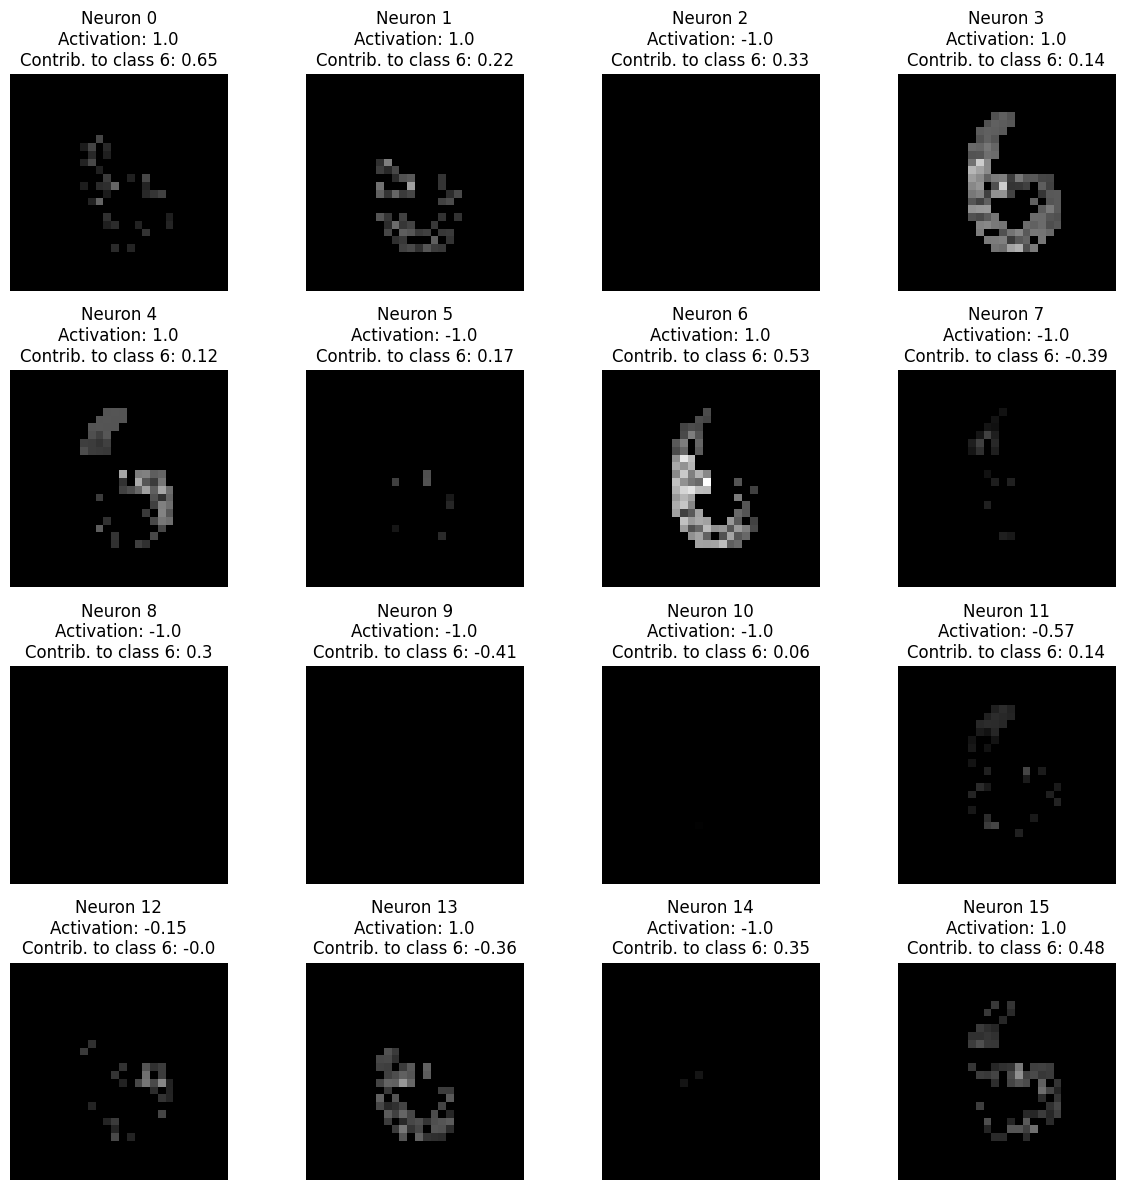

In [18]:
weights_fc1 = net.fc1.weight.detach().cpu().unsqueeze(-1).unsqueeze(-1)
biases_fc1 = net.fc1.bias.detach().cpu()

combined = (weights_fc1 * contribs_imgs.unsqueeze(0)).sum(dim=1)
max_val = combined.max()
combined = combined / max_val

mask = torch.where(
    combined == 0,
    torch.tensor(0.0, device=combined.device),
    torch.tensor(1.0, device=combined.device)
)

combined += biases_fc1[:, None, None]
combined *= mask

combined_copy = combined.clone() #using this to determine activations, in case that combined will be modified for visual benefits

per_img_max = combined.view(len(combined), -1).max(dim=1)[0]
thresholds = (0.25 * per_img_max).view(len(combined), 1, 1)

combined = torch.where(
    combined == 0,
    torch.tensor(0.0, device=combined.device),
    torch.where(
        combined > thresholds,
        combined,
        torch.tensor(0.0, device=combined.device)
    )
)

weights_fc2 = net.fc2.weight.detach().cpu()
activations = [torch.tanh(mat.sum()).squeeze() for mat in combined_copy]

contribs_out_class = [round(activations[idx].item() * weights_fc2[bin_digit, idx].item(), 2) for idx in range(16)]
vmax = combined.max().item()

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
for idx, ax in enumerate(axes.flat):
    ax.imshow(combined[idx].cpu(), cmap='gray', vmin=0, vmax=vmax)
    ax.axis('off')
    ax.set_title(f'Neuron {idx}\nActivation: {round(activations[idx].item(), 2)}\nContrib. to class {bin_digit}: {contribs_out_class[idx]}')

plt.tight_layout()
plt.show()
